<a href="https://colab.research.google.com/github/thiagomelostuckert/datathon-fakenews/blob/main/3_Telegram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Estruturação de aplicação para detecção de notícias a partir da extração de mensagens em grupo do Telegram

Agora que o modelo já foi treinado é preciso analisar a performance dele em tempo real. Em parceria com um órgão do XX, a fração de D&A recebeu informações sobre um grupo de Telegram em que há suspeita de desinformação. Quando estiver em posse do modelo treinado, a equipe pode buscar representantes do desafio para obter o link do grupo.
O engenheiro de dados deverá desenvolver aplicação que acompanha constantemente o grupo designado. Na ocorrência de uma mensagem nesse grupo, a aplicação deverá:

i) preprocessar o texto da mesma forma que na etapa 1;

ii) carregar os parâmetros do modelo treinado na etapa 2;

iii) realizar inferência no texto processado, gerando previsão de se a notícia é falsa ou não;

iv) salvar o texto, o timestamp de recebimento da mensagem, o timestamp após a realização da inferência e a previsão do modelo para aquela notícia em um pandas dataframe;

v) ao fim do recebimento das mensagens (será indicado ao grupo), deverá salvar o pandas dataframe em formato .csv.

Recomenda-se a utilização da biblioteca python telethon, que é assíncrona (deve ser utilizada conjuntamente à biblioteca asyncio). É possível utilizar a biblioteca no Google Colab (nesse caso, deve utilizar ainda o nest_asyncio). Para utilizar a biblioteca telethon é necessário também obter os dados da API do Telegram, que pode ser feito utilizando esse link (https://core.telegram.org/api/obtaining_api_id).

Serão considerados na avaliação: intervalo de tempo entre o recebimento da mensagem e a realização da inferência; eficiência do código.

Importação das bibliotecas

In [162]:
import pandas as pd
import datetime

#Extração das mensagens do grupo do telegram
#!pip install Telethon
from telethon import TelegramClient, events
import asyncio
import nest_asyncio


import json

# Pré-processamento
import nltk
from nltk.stem import RSLPStemmer
from nltk.stem.wordnet import WordNetLemmatizer



Extração dos textos do grupo de telegram

Realizei os seguintes passos para obter as credenciais de acesso do Telegram:

1) Acessei o site [my.telegram.org](https://);

2) Informei o número do meu celular;

3) Recebi um código de verificação;

4) Digitei o código de verificação no site;

5) Acessei a opção "API development tools", preenchi o formulário conforme
imagem abaixo;

6) Cliquei em "Create application";

7) Recebi o App api_id e o App api_hash.

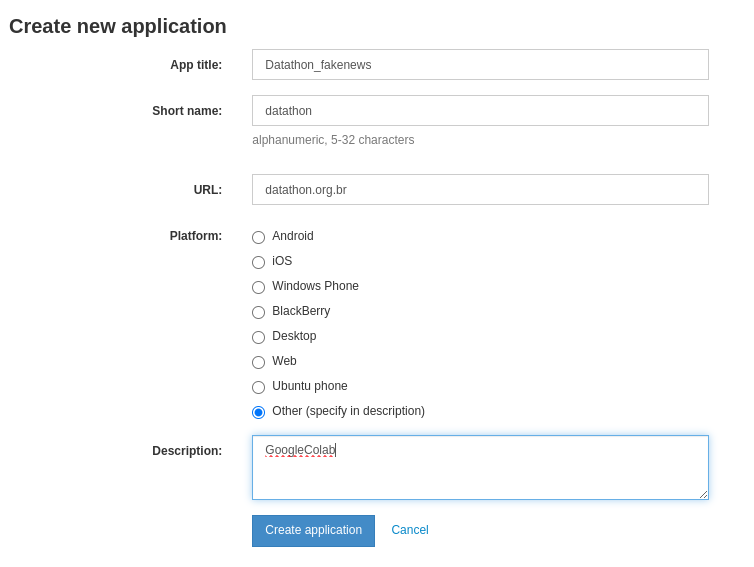

Referências:
https://www.itpanther.com/scrape-telegram-group-messages/
https://arabic-telethon.readthedocs.io/en/stable/extra/examples/telegram-client.html#getting-messages

In [163]:
#Leitura das credenciais de acesso ao telegram
file_path = "/content/telegram_app_configuration.json"
try:
  with open(file_path, 'r') as f:
    app_config = json.load(f)
    api_id=app_config["api_id"]
    api_hash=app_config["api_hash"]
    phone_number=app_config["phone_number"]
    print("Carregou as credenciais do telegram com sucesso.")
except Exception as error:
  print("Falha ao carregar as credenciais do telegram.")
  print(f"Exceção: {error} ")

Carregou as credenciais do telegram com sucesso.


In [164]:
print("Phone Number: ",phone_number)

Phone Number:  5561998210957


https://buildmedia.readthedocs.org/media/pdf/telethon/stable/telethon.pdf

In [192]:
nest_asyncio.apply()
client = TelegramClient('datathon', api_id, api_hash)
chat = ["Teste Datathon"]
df = pd.DataFrame()

In [205]:
async def get_all_messages():
  #async for message in client.iter_messages('me'):
  #  print(message.id, message.text)

  # ,offset_date=datetime.date.today()
  async for message in client.iter_messages("testestuckert"):
    print(message.id, message.text)
  #         print(message.sender_id)
            #data = { "group" : chat, "sender" : message.sender_id, "text" : message.text, "date" : message.date}
            #temp_df = pd.DataFrame(data, index=[1])
            #df = df.append(temp_df)

In [206]:
async def main():
  client.loop.run_until_complete(get_all_messages())
  #await client.send_message("me", "Hello me!")

In [207]:
async with client:
  client.loop.run_until_complete(main())

2 Teste
1 None


In [208]:
client.disconnect()
print(df.head())

Empty DataFrame
Columns: []
Index: []


In [118]:
messages=[]

In [46]:
async def get_new_messages():
  async with TelegramClient('datathon', api_id, api_hash) as client:
    @client.on(events.NewMessage())
    async def my_event_handler(events):
      await print(event.message)

    await client.run_until_disconnected()

OperationalError: ignored

In [ ]:
df.head()

In [ ]:
file_name = "mensagens_{}.csv".format(datetime.date.today())
df.to_csv(file_name, index=False)

i) preprocessar o texto da mesma forma que na etapa 1;

No pré-processamento de linguagem natural é comum retirar palavras sem significado semântico (conhecidas em inglês como "stop words").

In [5]:
# Stopwords em português:
nltk.download('stopwords')
stopwordspt = nltk.corpus.stopwords.words('portuguese')
stopwordsen = nltk.corpus.stopwords.words('english')
stopwordspt[:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as']

Outro pré-processamento possível é a retirada de prefixos e sufixos desnecessários das palavras ( processo conhecido em inglês pelos termos "lemmatizing and stemming")

In [6]:
# Download lista de radicais e sufixos
!wget https://github.com/michmech/lemmatization-lists/raw/master/lemmatization-pt.txt -q
nltk.download('rslp')

ptstemmer = RSLPStemmer()
enstemmer = WordNetLemmatizer()

# Convert to dictionary
lmztpt = {}
dic = open("lemmatization-pt.txt")
for line in dic:
  txt = line.split()
  lmztpt[txt[1]] = txt[0]

# Lemmatize wherever possible
def PortugueseMess(word):
  if word in lmztpt.keys():
    return lmztpt.get(word)
  else:
    return ptstemmer.stem(word)

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


ii) carregar os parâmetros do modelo treinado na etapa 2;

iii) realizar inferência no texto processado, gerando previsão de se a notícia é falsa ou não;

iv) salvar o texto, o timestamp de recebimento da mensagem, o timestamp após a realização da inferência e a previsão do modelo para aquela notícia em um pandas dataframe;

v) ao fim do recebimento das mensagens (será indicado ao grupo), deverá salvar o pandas dataframe em formato .csv.